In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.features.soundlevel import soundlevel_for_file, compute_leq, compute_ln
from src.utils.fileutils import get_project_root
import diptest

In [2]:
ROOT = get_project_root()
data_root = os.path.join(ROOT, 'data/raw')
audio_root = os.path.join(data_root, 'development_audio/development_audio')
annotations_root = os.path.join(data_root, 'development_annotation/development_annotation')

In [3]:
scenes = os.listdir(audio_root)

In [4]:
scenes

['cafe_restaurant',
 'city_center',
 'grocery_store',
 'metro_station',
 'residential_area']

In [5]:
os.listdir(annotations_root)

['soft_labels_cafe_restaurant',
 'soft_labels_city_center',
 'soft_labels_grocery_store',
 'soft_labels_metro_station',
 'soft_labels_residential_area']

In [6]:
def get_annotation_filepath(scene: str = 'cafe_restaurant', file_id: str = '04') -> str:
    filename = f'{scene}_{file_id}.txt'
    scene_path = f'soft_labels_{scene}'
    return os.path.join(annotations_root, scene_path, filename)

In [7]:
def get_audio_path(scene: str = 'cafe_restaurant', file_id: str = '04'):
    filename = f'{scene}_{file_id}.wav'
    return os.path.join(audio_root, scene, filename)

In [8]:
def get_soundlevels(audio_path) -> pd.DataFrame:
    df, _ = soundlevel_for_file(audio_path)
    df = df.rename(columns={0: 'dBA'})
    return df

In [9]:
clip_name = []
dips = []
pvals = []
for scene in scenes:
    print(scene)
    clips = os.listdir(os.path.join(audio_root, scene))
    for clip in clips:
        #print(clip)
        clip_id = clip.split('_')[-1].split('.')[0]
        clip_path = get_audio_path(scene=scene, file_id=clip_id)
        ann_path = get_annotation_filepath(scene=scene, file_id=clip_id)
        #print(ann_path)
        
        df = get_soundlevels(clip_path)
        
        dip, pval = diptest.diptest(df['dBA'])
        clip_name.append(clip)
        dips.append(dip)
        pvals.append(pval)
        
dip_df = pd.DataFrame(data=list(zip(clip_name, dips, pvals)),
                         columns=['Clip', 'Dip Stat', 'P value'])
        
        

cafe_restaurant
city_center
grocery_store
metro_station
residential_area


In [10]:
# a low p-value indicates a likely bimodal distribution
dip_df.round(4)

,Clip,Dip Stat,P value
0,cafe_restaurant_00.wav,0.0021,1.0000
1,cafe_restaurant_04.wav,0.0026,0.9969
2,cafe_restaurant_06.wav,0.0028,0.9527
3,cafe_restaurant_07.wav,0.0022,0.9938
4,cafe_restaurant_08.wav,0.0030,0.9614
5,cafe_restaurant_10.wav,0.0025,0.9941
6,cafe_restaurant_11.wav,0.0023,0.9960
7,cafe_restaurant_12.wav,0.0032,0.9717
8,cafe_restaurant_13.wav,0.0033,0.9462
9,cafe_restaurant_14.wav,0.0032,0.9634


In [11]:
# sum of clips with significant bimodality
dip_df['P value'][dip_df['P value'] <= 0.05].count()

26

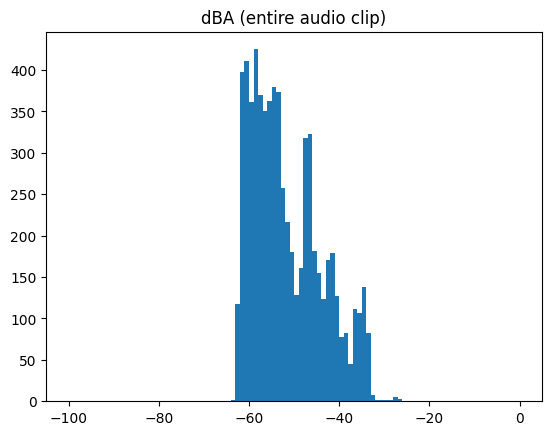

In [12]:
# plot the histogram for a LOW p-value file (metro_station_12.wav)
clip_path = get_audio_path(scene='metro_station', file_id='12')
df = get_soundlevels(clip_path)
db_bins = [i for i in range(-100, 1)]
plt.hist(df['dBA'], bins=db_bins)
plt.title('dBA (entire audio clip)')
plt.show()

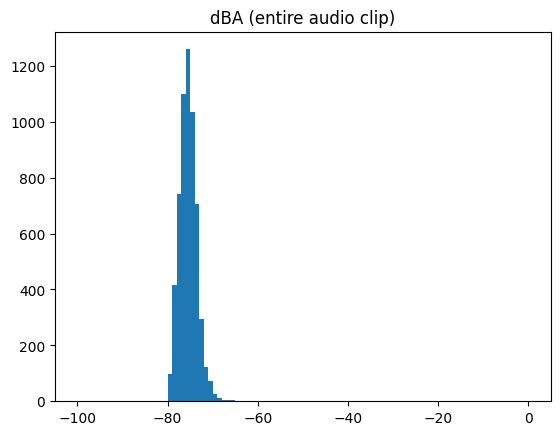

In [13]:
# plot the histogram for a HIGH p-value file (residential_area_01.wav)
clip_path = get_audio_path(scene='residential_area', file_id='01')
df = get_soundlevels(clip_path)
db_bins = [i for i in range(-100, 1)]
plt.hist(df['dBA'], bins=db_bins)
plt.title('dBA (entire audio clip)')
plt.show()